$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bs}{\mathbf{s}}
\newcommand{\sn}{s^{(n)}}
\newcommand{\bsn}{\bs^{(n)}}
\newcommand{\bxn}{\bx^{(n)}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
\newcommand{\tr}{\textrm{Tr}}
\newcommand{\ssq}{\sigma^2}
\newcommand{\expect}[1]{\langle {#1} \rangle}
$$

## Bernoulli Mean-field Demo

In [4]:
import matplotlib.pyplot as plt
import numpy as np

np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Prepare data

The images were randomly generated by combining several binary feature vectors and adding Gaussian noise. Examples shown below.

In [5]:
X = np.array(np.loadtxt('../data/bernoulli_features.txt'))
N, D = X.shape

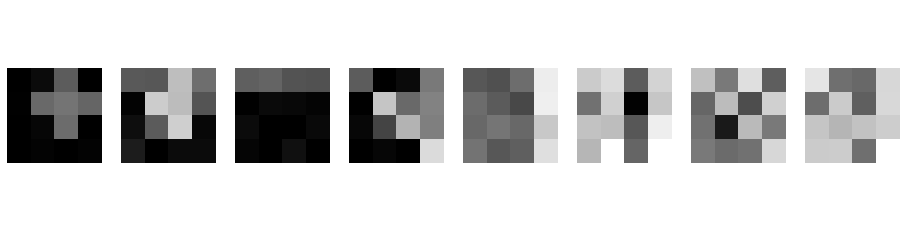

In [6]:
fig = plt.figure(figsize=(16,4))
for n in range(1, 8 + 1):
    ax = plt.subplot(1, 8, n)
    ax.set_facecolor((0.2, 0.4, 0.6))
    ax.imshow(X[n].reshape(4, 4), cmap='gray',vmin=0,vmax=2, interpolation='none')
    ax.axis('equal')
    ax.set_axis_off()
plt.show()

### Model

The model is as follows:

\begin{align}
    P(\bs) &= \prod_i^K P(s_i) = \prod_i^K \pi_i^{s_i}(1-\pi_i)^{1-s_i} \\
    P(\bx \mid \bs) &= \calN(\sum_i^K s_i \mu_i, \sigma^2 I_D)
\end{align}

We use a mean-field approximation to the posterior, i.e. for each data point we have

\begin{equation}
    q_n(\bsn) = \prod_i^K \Lambda_{in}^{\sn_i}(1-\Lambda_{in})^{1-{\sn_i}}
\end{equation}

with $\expect{\sn_i}_{q_{in}} = \Lambda_{in}$. The full log-joint is

\begin{align}
    \log \prod_n P(\bxn \mid \bsn) P(\bsn) &\propto -\frac{1}{2\ssq} \sum_n (\bxn - \sum_i^K \sn_i \mu_i)^T(\bxn - \sum_i^K \sn_i \mu_i) + \sum_n \sum_i \sn_i \log \frac{\pi_i}{1-\pi_i} \\
    &\propto -\frac{1}{2\ssq} [\sum_{ij} \mu_i^T \mu_j \sum_n \sn_i \sn_j - 2 \sum_i \mu_i^T \sum_n \sn_i \bxn] + \sum_n \sum_i \sn_i \log \frac{\pi_i}{1-\pi_i} \\
    &= -\frac{1}{2\ssq} [\sum_n \sum_i \sn_i \mu_i^T \mu_i + \sum_n \sum_i \sn_i \mu_i^T \sum_{j \neq i} \sn_j \mu_j  - 2 \sum_n \sum_i \sn_i \mu_i^T \bxn] + \sum_n \sum_i \sn_i \log \frac{\pi_i}{1-\pi_i}
\end{align}

$\textbf{Variational updates}$

The optimal $q_{in}(\sn_i)$ maximising the free energy is given by 

\begin{align}
    q_{in}(\sn_i) &= \exp [\expect{\log \prod_n P(\bxn \mid \bsn) P(\bsn)}_{q_{\setminus i, n}} ] \\ 
    &\propto \exp [ -\frac{1}{2\ssq} [\sn_i \mu_i^T \mu_i + 2 \sn_i \mu_i^T \sum_{j \neq i} \Lambda_{jn} \mu_j  - 2 \sn_i \mu_i^T \bxn] + \sn_i \log \frac{\pi_i}{1-\pi_i} ] \\
    &= \exp [\sn_i \alpha_{in}]
\end{align}

We need to re-arrange the original $q_{in}$ in a form that will make it clear how $\Lambda_{in}$ and $\alpha_{in}$ are related.

\begin{align}
q_{in}(\sn_i) &= \Lambda_{in}^{\sn_i}(1-\Lambda_{in})^{1-{\sn_i}} = \exp \log \Lambda_{in}^{\sn_i}(1-\Lambda_{in})^{1-{\sn_i}} \propto \exp \sn_i \log \frac{\Lambda_{in}}{1-\Lambda_{in}} \\
\Rightarrow \alpha_{in} &= \log \frac{\Lambda_{in}}{1-\Lambda_{in}} \Rightarrow \Lambda_{in} = \text{sigmoid}(\alpha_{in})
\end{align}

$\textbf{Expectations}$

For the M-step, the expectations we will need are $\expect{\sn_i}_{q_n}, \expect{\sn_i \sn_j}_{q_n}$. These are

\begin{align}
    \expect{\sn_i}_{q_n} &= \lambda_{in} \\
    \expect{\sn_i \sn_j}_{q_n} &= \lambda_{in} \lambda_{jn} + \delta_{ij}(\lambda_{in} - \lambda_{in} \lambda_{jn})
\end{align}

$\textbf{M-step}$

We state M-step updates without derivation:

\begin{align}
    \pi_i &= \frac{1}{N} \sum_n \expect{\sn_i}_{q_n} \\
    \mu_j &= \sum_i [\sum_n \expect{\sn_i \sn_j}_{q_n}]^{-1} \sum_n \expect{\sn_i}_{q_n} \bxn \\
    \ssq &= \frac{1}{ND}[\sum_n \bxn {}^T \bxn + \sum_i \sum_j \mu_i^T \mu_j \sum_n \expect{\sn_i \sn_j}_{q_n} -2 \sum_i \mu_i^T \sum_n \expect{\sn_i}_{q_n} \bxn]
\end{align}

In [7]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [8]:
def mask_column(A, col):
    mask = np.ones_like(A)
    mask[:, col] = 0
    return A * mask

In [9]:
def free_energy(X, Q_params, model_params):
    N, D = X.shape
    L = Q_params
    pi, mu, sigmasq = model_params
    
    F_H = - np.sum(L * np.nan_to_num(np.log(L))
                   + (1 - L) * np.nan_to_num(np.log(1 - L)), axis=1)

    F_Q = L @ np.log(pi) + (1 - L) @ np.log(1 - pi)

    F_norm = - D / 2 * np.log(2 * np.pi * sigmasq)

    mhlb = np.diag((X - L @ mu.T) @ (X - L @ mu.T).T) + (L - L**2) @ np.diag(mu.T @ mu)

    return np.sum(F_H + F_Q + F_norm - 1 / (2 * sigmasq) * mhlb)

In [10]:
def mean_field(X, Q_params, model_params, max_steps=100, eps=1e-4):
    L = Q_params
    pi, mu, sigmasq = model_params
    K = L.shape[1]
    
    pi_log = np.log(pi / (1 - pi))
    mu_diag = np.diag(mu.T @ mu)
    muTx = X @ mu

    c = 0
    delta = 1.0
    prev_F = -100000
    
    while abs(delta) > eps and c < max_steps:
        F = free_energy(X, L, model_params)
        delta = F - prev_F
        prev_F = F
        c += 1
        
        for i in range(K):
            Lmu = L @ mask_column(mu, i).T
            L[:, i] = sigmoid(
                pi_log[i] 
                - 1 / sigmasq * (0.5 * mu_diag[i] - muTx[:, i] + Lmu @ mu[:, i])
            )
        
    return L, F

In [11]:
def E(Q_params):
    L = Q_params
    es = L
    ess = L[..., None] @ L[:, None, :]
    ess = np.sum(ess, axis=0)
    np.fill_diagonal(ess, np.sum(es, axis=0))
    return es, ess

In [12]:
def M(X, expectations):
    N, D = X.shape
    es, ess = expectations
    
    esTx = es.T @ X
    pi = np.mean(es, axis=0)
    mu = np.linalg.solve(ess, esTx).T
    sigmasq = 1 / (N * D) * (np.trace(X.T @ X) + np.trace(mu.T @ mu @ ess) - 2 * np.trace(esTx @ mu))
    
    return pi, mu, sigmasq

In [13]:
def initialise_model_params(D, K):
    pi = np.clip(0.2 + 0.1 * np.random.rand(K), 0, 1)
    mu = 0.5 * np.ones((D, K))
    mu += 0.1 * np.random.normal(0, 1, (D, K))
    sigmasq = 0.25
    return pi, mu, sigmasq

def initialise_q_params(N, K):
    L = np.random.rand(N,K)
    return L

In [14]:
def learn_factors(X, K, iterations=100, eps=1e-6):
    N, D = X.shape
    
    pi, mu, sigmasq = initialise_model_params(D, K)
    L = initialise_q_params(N, K)
    
    Fs = []
    prev_F = -1e10
    for _ in range(iterations):
        L, F = mean_field(X, L, (pi, mu, sigmasq))
        
        if F-prev_F < -1e-10:
            print("F increased from {} to {}".format(prev_F, F))
        if F-prev_F < eps:
            print("Convergence criterion satisfied, terminating.") 
            break
        prev_F = F
        Fs.append(F)
        
        es, ess = E(L)

        pi, mu, sigmasq = M(X, (es, ess))
        
    return (pi, mu, sigmasq), Fs

In [15]:
learned_params, Fs = learn_factors(X, 8, 80)

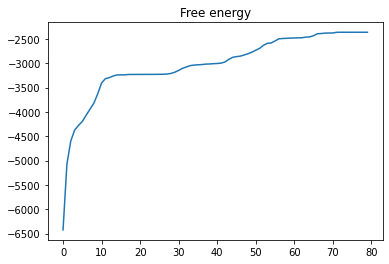

In [16]:
plt.title("Free energy")
plt.plot(Fs)
plt.show()

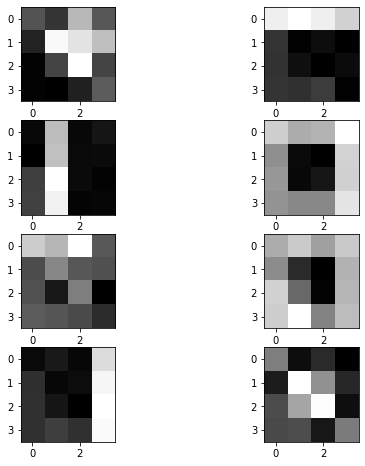

In [17]:
# Show learned means.
_, learned_mu, _ = learned_params
fig = plt.figure(figsize=(8, 8))
for n in range(1, 8 + 1):
    ax = plt.subplot(4, 2, n)
    ax.imshow(learned_mu[:, n - 1].reshape(4, 4),cmap='gray', interpolation='none')
plt.show()